<a href="https://colab.research.google.com/github/zahraDehghanian97/Self_Organizing_Map/blob/master/SOFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# prerequisit

In [36]:
try :
  %tensorflow_version 2.x
except:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
from csv import reader
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from PIL import Image
import glob
import random


## mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **make dataset ready**

In [85]:
def load_photos(dir_name):
    photo_list =[]
    name_list = []
    labels = []
    for file_name in (glob.glob(dir_name+'/*')):
        image = Image.open(file_name)
        photo_list.append(np.array(image).flatten())
        x = file_name.split('/')
        name_list.append(x[6])
        labels.append(x[6].split('.')[1])
    return photo_list , name_list , labels
  
    

dir_name = "/content/drive/MyDrive/Colab Notebooks/yalefaces"
X , name_list , y = load_photos(dir_name)
X = np.array(preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(X))
n_features = X.shape[1]
print(n_features)
print(X.shape)

77760
(165, 77760)


# **SOM Class**

Iteration: 0, LR: 0.100000, R: 2.000000, J: 25.694724
Iteration: 1, LR: 0.099000, R: 1.980000, J: 23.066887
Iteration: 2, LR: 0.098000, R: 1.960000, J: 16.066300
Iteration: 3, LR: 0.097000, R: 1.940000, J: 14.214478
Iteration: 4, LR: 0.096000, R: 1.920000, J: 12.929690
Iteration: 5, LR: 0.095000, R: 1.900000, J: 11.510729
Iteration: 6, LR: 0.094000, R: 1.880000, J: 10.314386
Iteration: 7, LR: 0.093000, R: 1.860000, J: 9.290147
Iteration: 8, LR: 0.092000, R: 1.840000, J: 8.647359
Iteration: 9, LR: 0.091000, R: 1.820000, J: 7.173250
Iteration: 10, LR: 0.090000, R: 1.800000, J: 6.505927
Iteration: 11, LR: 0.089000, R: 1.780000, J: 6.269587
Iteration: 12, LR: 0.088000, R: 1.760000, J: 5.560867
Iteration: 13, LR: 0.087000, R: 1.740000, J: 4.934165
Iteration: 14, LR: 0.086000, R: 1.720000, J: 4.503457
Iteration: 15, LR: 0.085000, R: 1.700000, J: 4.163027
Iteration: 16, LR: 0.084000, R: 1.680000, J: 4.005179
Iteration: 17, LR: 0.083000, R: 1.660000, J: 3.611306
Iteration: 18, LR: 0.082000, R:

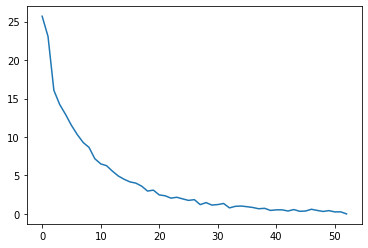

In [95]:
class SOM:
    def __init__(self, map_size, lr = 0.1):
        self.map = np.zeros(shape=map_size)
        self.lr0 = lr
        self.lr = self.lr0
        self.R0 = map_size[0]//2
        self.R = self.R0
        
    def train(self, X, y, T=1000, error_threshold=10**-20): 
        Js = []
        for t in range(T):
            prev_map = np.copy(self.map)
            shuffle_ind = np.random.randint(low=0, high=len(X), size=len(X))  # a vector of random indices
            for i in range(len(X)):
                x = X[shuffle_ind[i],:]
                x = np.asarray(x)
                winner = self.find_winner(x)    # winner = [1,4]
                NS = self.get_NS(winner)
                self.update_weights(x, NS, len(X))
            self.lr = self.lr0 * (1 - t/T)
            self.R = self.R0 * (1 - t/T)
            Js.append(np.linalg.norm(prev_map - self.map))     # norm of changes
            # if t % 10 == 0:
            #     print('Iteration: %d, LR: %f, R: %f, J: %f' %(t, self.lr, self.R, Js[-1]))
            print('Iteration: %d, LR: %f, R: %f, J: %f' %(t, self.lr, self.R, Js[-1]))
                # self.visualize(X, y)
            if Js[-1] < error_threshold:
                print('Min changes')
                break
        return Js
            
    def visualize(self, X, y):
        self.scores = np.zeros(shape=(self.map.shape[0], self.map.shape[1], 3))  
        for i in range(len(X)):
            x = X[i, :]
            x = np.asarray(x)
            winner = self.find_winner(x)
            iw, jw = winner[0], winner[1]
            if y[i] == -1:
                self.scores[iw, jw] += np.asarray([1, 0, 0])
            if y[i] == 1:
                self.scores[iw, jw] += np.asarray([0, 0, 1])
            if y[i] == 0:
                self.scores[iw, jw] += np.asarray([0, 1, 0])
        self.scores = self.scores / np.mean(np.mean(self.scores))
        plt.imshow(self.scores)
        plt.show()
        
    def find_winner(self, x):
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        dists = np.sum((self.map - rep_x)**2, axis=2)   
        winner = np.unravel_index(np.argmin(dists, axis=None), dists.shape)
        return winner
    
    def get_NS(self, winner):
        # not neighbor = 0 , neighbor = 1/sqrt(euclidean_distance)
        NS = np.zeros(shape= (self.map.shape[0], self.map.shape[1]))
        iw, jw = winner[0], winner[1]
        R = int(self.R)
        for ri in range(-R, R):
            for rj in range(-R, R):
                if (0 <= iw + ri < self.map.shape[0]) and  (0 <= jw + rj < self.map.shape[1]):   
                    NS[iw + ri, jw + rj] = 0 if np.sqrt(ri**2 + rj**2) > R else 1/ ( 1+ np.sqrt(ri**2 + rj**2))  
        return NS
    
    def update_weights(self, x, n_strength, X_len):
        NS = np.tile(n_strength, [self.map.shape[2],1,1]).transpose()
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        Delta = rep_x - self.map 
        self.map = self.map + (self.lr/X_len) * np.multiply(NS, Delta)
  
    def extract_feature(self, x): # here we give a data of n feature and take a matrix of size map as output (e.g, 9*9)
        x = np.asarray(x)
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[0], 1])
        dists = np.sum((self.map - rep_x)**2, axis=2)
        return 1/ (1 + dists)
     
   
m_size = 4
som_net = SOM(map_size = [m_size,m_size,n_features])
Js = som_net.train(X, y, T = 100)
plt.plot(Js)
plt.show()
# som_net.visualize(X, y)
# x = X[0,:]
# features = som_net.extract_feature(x)
# plt.imshow(features)
# plt.show()
    